In [53]:
import os
os.chdir("/Users/cornederuijt/github/GCM/") # Adjust after construction of the package

import numpy as np
import pandas as pd
import pickle as pl
from plotnine import *
from scripts.clickmodel_fitters.clickdefinitionreader import ClickDefinition
from scripts.clickmodel_fitters.GCM import GCM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.initializers import Zeros
from scipy.linalg import norm
from copy import deepcopy

np.random.seed(1992)

In [2]:
# Define the model

list_size = 10
no_states = 7
click_states = np.zeros((no_states, list_size + 1))
click_states[3, :] = 1
abs_state = [(i, 6) for i in range(7)]
init_state = 3  # Equals the click state
batch_size = 10000
no_items = 100

var_dic = {
    'gamma': {
        'var_type': 'session',
        't0_fixed': 1,  # Always continues to evaluate the first item
        'pos_mat': np.vstack((np.zeros((2, no_states)),
                              np.array([0, 0, 1, 1, 0, 0, 0]),
                              np.array([0, 0, 1, 1, 0, 0, 0]),
                              np.zeros((3, no_states)))),
        'neg_mat': np.vstack((np.zeros((2, no_states)),
                              np.array([1, 1, 0, 0, 0, 0, 0]),
                              np.array([1, 1, 0, 0, 0, 0, 0]),
                              np.zeros((3, no_states)))),
        'fixed_mat': np.vstack((np.zeros((3, no_states)),
                                np.array([0, 0, 0, 0, 1, 1, 0]),
                                np.zeros((3, no_states))))
    },
    'phi_S': {
        'var_type': 'item',
        't0_fixed': 0,  # Never satisfied in the first state
        'pos_mat': np.vstack((np.zeros((3, no_states)),
                              np.array([0, 0, 0, 0, 1, 1, 0]),
                              np.zeros((3, no_states)))),
        'neg_mat': np.vstack((np.zeros((3, no_states)),
                              np.array([1, 1, 1, 1, 0, 0, 0]),
                              np.zeros((3, no_states)))),
        'fixed_mat': np.vstack((np.zeros((2, no_states)),
                                np.array([1, 1, 1, 1, 0, 0, 0]),
                                np.zeros((4, no_states))))
    },
    'phi_A': {
        'var_type': 'item',
        'pos_mat': np.vstack((np.zeros((2, no_states)),
                              np.array([0, 1, 0, 1, 0, 0, 0]),
                              np.array([0, 1, 0, 1, 0, 1, 0]),
                              np.zeros((3, no_states)))),
        'neg_mat': np.vstack((np.zeros((2, no_states)),
                              np.array([1, 0, 1, 0, 0, 0, 0]),
                              np.array([1, 0, 1, 0, 1, 0, 0]),
                              np.zeros((3, no_states))))
    }
}

model_def = ClickDefinition(click_states, init_state, list_size, no_states, batch_size, no_items, abs_state,
                            var_dic)

In [3]:
# Load data:
click_data = pd.read_csv("./data/small_example/simulation_res_train.csv", index_col=False)
prod_position = pd.read_csv("./data/small_example/simulation_item_props.csv", index_col=False)

    
# Ensure the order is correct:
click_data = click_data.sort_values(['user_id', 'session_count', 'item_order'])
    
# Add session index:
session_index = (click_data
                 .loc[:, ['user_id', 'session_count']] 
                 .drop_duplicates() 
                 .reset_index()
                )

session_index['session'] = session_index.index.to_numpy()

click_data = (click_data 
    .set_index(['user_id', 'session_count']) 
    .join(session_index
          .set_index(['user_id', 'session_count']),
          on=['user_id', 'session_count']) 
    .reset_index()
    .set_index('item')
    .join(prod_position
         .set_index('item'),
         on='item')
    .reset_index()
)

click_data

    

,item,user_id,session_count,item_order,click,attr,satis,eval,orig_list_id,index,session,X0,X1
0,42,0,0,1,0.0,0,0,1.0,0,0,0,-0.617880,-0.424150
1,66,0,0,2,0.0,0,0,1.0,0,0,0,-0.463804,-0.667938
2,89,0,0,3,0.0,0,0,1.0,0,0,0,-0.849402,1.813430
3,64,0,0,4,0.0,0,0,1.0,0,0,0,-1.875517,-1.026840
4,25,0,0,5,0.0,0,0,1.0,0,0,0,-0.908807,0.050236
...,...,...,...,...,...,...,...,...,...,...,...,...,...
250565,85,17999,2,6,0.0,0,0,0.0,35807,250560,25056,-0.362179,-0.737943
250566,3,17999,2,7,0.0,1,0,0.0,35807,250560,25056,0.136692,0.039374
250567,76,17999,2,8,0.0,1,0,0.0,35807,250560,25056,0.257214,-0.653226
250568,64,17999,2,9,0.0,0,0,0.0,35807,250560,25056,-1.875517,-1.026840


In [4]:
# Create the click matrix and item position matrix
click_mat = click_data.loc[:, ['session', 'item_order', 'click']] \
    .pivot(index='session', columns='item_order', values='click') \
    .to_numpy()

item_pos_mat = click_data.loc[:, ['session', 'item_order', 'item']] \
    .pivot(index='session', columns='item_order', values='item') \
    .to_numpy()

In [5]:
# Create feature matrix for phi_A, phi_S and gamma
item_feature_mat_A = (click_data.loc[:, ['item', 'X0', 'X1']] 
                                .drop_duplicates() 
                                .sort_values('item')
                                .to_numpy()
                     )
item_feature_mat_S = deepcopy(item_feature_mat_A)

n_sessions = click_data['session'].nunique()
gamma_feature_mat = np.ones((n_sessions, 1))

In [6]:
# Define the Keras models
model_phi_A = Sequential()
model_phi_A.add(Dense(1, input_dim=item_feature_mat_A.shape[1], activation='sigmoid', use_bias=False,
                     kernel_initializer=Zeros()))
model_phi_A.compile(loss=GCM.pos_log_loss, optimizer=RMSprop())

model_phi_S = Sequential()
model_phi_S.add(Dense(1, input_dim=item_feature_mat_S.shape[1], activation='sigmoid', use_bias=False,
                     kernel_initializer=Zeros()))
model_phi_S.compile(loss=GCM.pos_log_loss, optimizer=RMSprop())

model_gamma = Sequential()
model_gamma.add(Dense(1, input_dim=gamma_feature_mat.shape[1], activation='sigmoid', use_bias=False,
                     kernel_initializer=Zeros()))
model_gamma.compile(loss=GCM.pos_log_loss, optimizer=RMSprop())


var_dic = {'phi_A': item_feature_mat_A, 'phi_S': item_feature_mat_S, 'gamma': gamma_feature_mat}
var_models = {'phi_A': model_phi_A, 'phi_S': model_phi_S, 'gamma': model_gamma}

In [54]:
# Run model
res = GCM.runEM(click_mat, var_dic, var_models, item_pos_mat, model_def, verbose=True)


Iteration: 0
Running E-step ...
Current conditional entropy:0.32146
Running M-step ...
Epoch 1/250
1/1 [==============================] - 0s 2ms/step - loss: 0.6909
Epoch 2/250
1/1 [==============================] - 0s 653us/step - loss: 0.6909
Epoch 3/250
1/1 [==============================] - 0s 495us/step - loss: 0.6909
Epoch 4/250
1/1 [==============================] - 0s 737us/step - loss: 0.6909
Epoch 5/250
1/1 [==============================] - 0s 505us/step - loss: 0.6909
Epoch 6/250
1/1 [==============================] - 0s 565us/step - loss: 0.6909
Epoch 7/250
1/1 [==============================] - 0s 503us/step - loss: 0.6909
Epoch 8/250
1/1 [==============================] - 0s 599us/step - loss: 0.6909
Epoch 9/250
1/1 [==============================] - 0s 2ms/step - loss: 0.6910
Epoch 1/250
1/1 [==============================] - 0s 623us/step - loss: 0.4085
Epoch 2/250
1/1 [==============================] - 0s 478us/step - loss: 0.4078
Epoch 3/250
1/1 [====================

1/1 [==============================] - 0s 467us/step - loss: 0.3608
Epoch 8/250
1/1 [==============================] - 0s 526us/step - loss: 0.3608
Epoch 9/250
1/1 [==============================] - 0s 421us/step - loss: 0.3608
Epoch 10/250
1/1 [==============================] - 0s 434us/step - loss: 0.3608
Epoch 11/250
1/1 [==============================] - 0s 458us/step - loss: 0.3608
Epoch 12/250
1/1 [==============================] - 0s 614us/step - loss: 0.3608
Epoch 13/250
1/1 [==============================] - 0s 460us/step - loss: 0.3608
Epoch 14/250
1/1 [==============================] - 0s 460us/step - loss: 0.3608
Epoch 15/250
1/1 [==============================] - 0s 473us/step - loss: 0.3608
Epoch 16/250
1/1 [==============================] - 0s 618us/step - loss: 0.3608
Epoch 17/250
1/1 [==============================] - 0s 560us/step - loss: 0.3608
Epoch 18/250
1/1 [==============================] - 0s 662us/step - loss: 0.3608
Epoch 19/250
1/1 [=========================

1/1 [==============================] - 0s 595us/step - loss: 0.3297
Epoch 4/250
1/1 [==============================] - 0s 485us/step - loss: 0.3297
Epoch 5/250
1/1 [==============================] - 0s 610us/step - loss: 0.3297
Epoch 6/250
1/1 [==============================] - 0s 484us/step - loss: 0.3297
Epoch 7/250
1/1 [==============================] - 0s 728us/step - loss: 0.3297
Epoch 8/250
1/1 [==============================] - 0s 504us/step - loss: 0.3297
Epoch 9/250
1/1 [==============================] - 0s 630us/step - loss: 0.3297
Epoch 10/250
1/1 [==============================] - 0s 507us/step - loss: 0.3297
Epoch 11/250
1/1 [==============================] - 0s 583us/step - loss: 0.3297
Epoch 12/250
1/1 [==============================] - 0s 494us/step - loss: 0.3297
Epoch 13/250
1/1 [==============================] - 0s 598us/step - loss: 0.3297
Epoch 14/250
1/1 [==============================] - 0s 471us/step - loss: 0.3297
Epoch 15/250
1/1 [=============================

1/1 [==============================] - 0s 2ms/step - loss: 0.6902
Epoch 2/250
1/1 [==============================] - 0s 618us/step - loss: 0.6901
Epoch 3/250
1/1 [==============================] - 0s 573us/step - loss: 0.6901
Epoch 4/250
1/1 [==============================] - 0s 608us/step - loss: 0.6901
Epoch 5/250
1/1 [==============================] - 0s 479us/step - loss: 0.6901
Epoch 6/250
1/1 [==============================] - 0s 563us/step - loss: 0.6901
Epoch 7/250
1/1 [==============================] - 0s 687us/step - loss: 0.6901
Epoch 8/250
1/1 [==============================] - 0s 503us/step - loss: 0.6901
Epoch 9/250
1/1 [==============================] - 0s 575us/step - loss: 0.6902
Epoch 10/250
1/1 [==============================] - 0s 508us/step - loss: 0.6902
Epoch 1/250
1/1 [==============================] - 0s 651us/step - loss: 0.2695
Epoch 2/250
1/1 [==============================] - 0s 471us/step - loss: 0.2688
Epoch 3/250
1/1 [==============================] - 0s

1/1 [==============================] - 0s 522us/step - loss: 0.2302
Epoch 5/250
1/1 [==============================] - 0s 585us/step - loss: 0.2302
Epoch 6/250
1/1 [==============================] - 0s 593us/step - loss: 0.2302
Epoch 7/250
1/1 [==============================] - 0s 484us/step - loss: 0.2302
Epoch 8/250
1/1 [==============================] - 0s 651us/step - loss: 0.2302
Epoch 9/250
1/1 [==============================] - 0s 557us/step - loss: 0.2302
Epoch 10/250
1/1 [==============================] - 0s 641us/step - loss: 0.2302
Epoch 11/250
1/1 [==============================] - 0s 546us/step - loss: 0.2302
Epoch 12/250
1/1 [==============================] - 0s 601us/step - loss: 0.2302
Epoch 13/250
1/1 [==============================] - 0s 492us/step - loss: 0.2302
Epoch 14/250
1/1 [==============================] - 0s 609us/step - loss: 0.2302
Epoch 15/250
1/1 [==============================] - 0s 524us/step - loss: 0.2302
Epoch 16/250
1/1 [============================

1/1 [==============================] - 0s 598us/step - loss: 0.1930
Epoch 7/250
1/1 [==============================] - 0s 572us/step - loss: 0.1930
Epoch 8/250
1/1 [==============================] - 0s 549us/step - loss: 0.1930
Epoch 9/250
1/1 [==============================] - 0s 593us/step - loss: 0.1930
Epoch 10/250
1/1 [==============================] - 0s 517us/step - loss: 0.1930
Epoch 11/250
1/1 [==============================] - 0s 624us/step - loss: 0.1930
Epoch 12/250
1/1 [==============================] - 0s 684us/step - loss: 0.1930
Epoch 13/250
1/1 [==============================] - 0s 717us/step - loss: 0.1930
Epoch 14/250
1/1 [==============================] - 0s 524us/step - loss: 0.1930
Epoch 15/250
1/1 [==============================] - 0s 582us/step - loss: 0.1930
Epoch 16/250
1/1 [==============================] - 0s 884us/step - loss: 0.1930
Epoch 17/250
1/1 [==============================] - 0s 560us/step - loss: 0.1930
Epoch 18/250
1/1 [==========================

7/7 [==============================] - 0s 715us/step - loss: 0.0826
Epoch 4/250
7/7 [==============================] - 0s 855us/step - loss: 0.0825
Epoch 5/250
7/7 [==============================] - 0s 746us/step - loss: 0.0825
Epoch 6/250
7/7 [==============================] - 0s 771us/step - loss: 0.0825
Epoch 7/250
7/7 [==============================] - 0s 783us/step - loss: 0.0825
Epoch 8/250
7/7 [==============================] - 0s 1ms/step - loss: 0.0826
Epoch 9/250
7/7 [==============================] - 0s 733us/step - loss: 0.0826
Iteration: 13
Current norm: 0.41728
Running E-step ...
Current conditional entropy:0.32151
Running M-step ...
Epoch 1/250
1/1 [==============================] - 0s 1ms/step - loss: 0.6872
Epoch 2/250
1/1 [==============================] - 0s 501us/step - loss: 0.6872
Epoch 3/250
1/1 [==============================] - 0s 579us/step - loss: 0.6871
Epoch 4/250
1/1 [==============================] - 0s 516us/step - loss: 0.6871
Epoch 5/250
1/1 [=========

1/1 [==============================] - 0s 541us/step - loss: 0.1480
Epoch 20/250
1/1 [==============================] - 0s 643us/step - loss: 0.1480
Epoch 21/250
1/1 [==============================] - 0s 527us/step - loss: 0.1480
Epoch 22/250
1/1 [==============================] - 0s 1ms/step - loss: 0.1480
Epoch 23/250
1/1 [==============================] - 0s 600us/step - loss: 0.1480
Epoch 24/250
1/1 [==============================] - 0s 486us/step - loss: 0.1480
Epoch 25/250
1/1 [==============================] - 0s 589us/step - loss: 0.1480
Epoch 26/250
1/1 [==============================] - 0s 466us/step - loss: 0.1480
Epoch 27/250
1/1 [==============================] - 0s 552us/step - loss: 0.1480
Epoch 28/250
1/1 [==============================] - 0s 473us/step - loss: 0.1480
Epoch 29/250
1/1 [==============================] - 0s 477us/step - loss: 0.1480
Epoch 30/250
1/1 [==============================] - 0s 588us/step - loss: 0.1480
Epoch 31/250
1/1 [=========================

In [8]:
pl.dump(res[1:3], open("./results/czm_res.pl", 'wb')) # Don't want to store final model, best model already stored

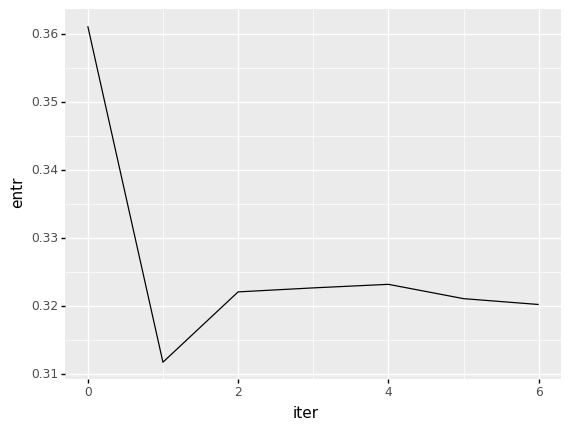

<ggplot: (8792213105345)>

In [8]:
(ggplot(pd.DataFrame(np.hstack((np.arange(len(res[2])).reshape(-1, 1), np.array(res[2]).reshape(-1 ,1))),
            columns=['iter', 'entr'])) +
 geom_line(aes(x='iter', y='entr'))
)


In [52]:
res

,item_order,click_mean,click_var,upper,lower
0,1,0.548270,0.247680,1.043630,0.052910
1,2,0.337311,0.223541,0.784393,-0.109771
2,3,0.203536,0.162116,0.527767,-0.120695
3,4,0.125514,0.109764,0.345043,-0.094015
4,5,0.076984,0.071061,0.219106,-0.065137
5,6,0.047691,0.045419,0.138529,-0.043146
6,7,0.029612,0.028737,0.087086,-0.027861
7,8,0.019116,0.018752,0.056620,-0.018387
8,9,0.011454,0.011323,0.034100,-0.011192
9,10,0.006705,0.006660,0.020025,-0.006615


In [9]:
# Combine the results:
phi_A_all = []
phi_S_all = []
gamma_all = []
for param_val in res[1]:
    phi_A_all.append(param_val['phi_A'].reshape(-1, 1))
    phi_S_all.append(param_val['phi_S'].reshape(-1, 1))
    gamma_all.append(param_val['gamma'][0])

phi_A_mat = np.hstack(phi_A_all)
phi_S_mat = np.hstack(phi_S_all)
gamma_mat = np.hstack(gamma_all)

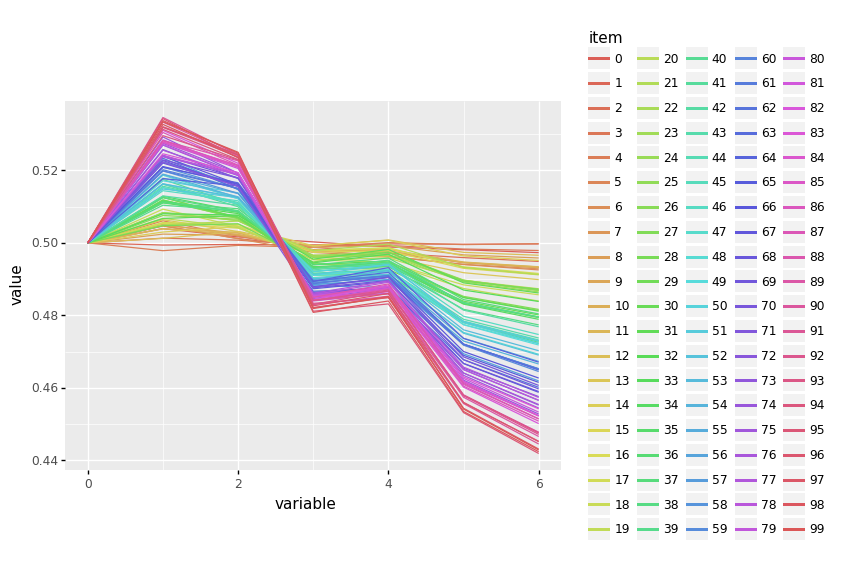

<ggplot: (8792235462138)>

In [10]:
phi_A_pd = pd.DataFrame(phi_A_mat)
phi_A_pd['item'] = np.arange(phi_A_pd.shape[0])
phi_A_pd = pd.melt(phi_A_pd, id_vars=['item'])
phi_A_pd['variable'] = phi_A_pd['variable'].astype(float)
phi_A_pd['item'] = phi_A_pd['item'].astype('category')

(ggplot(phi_A_pd) +
geom_line(aes(x='variable', y='value', color='item'))
)

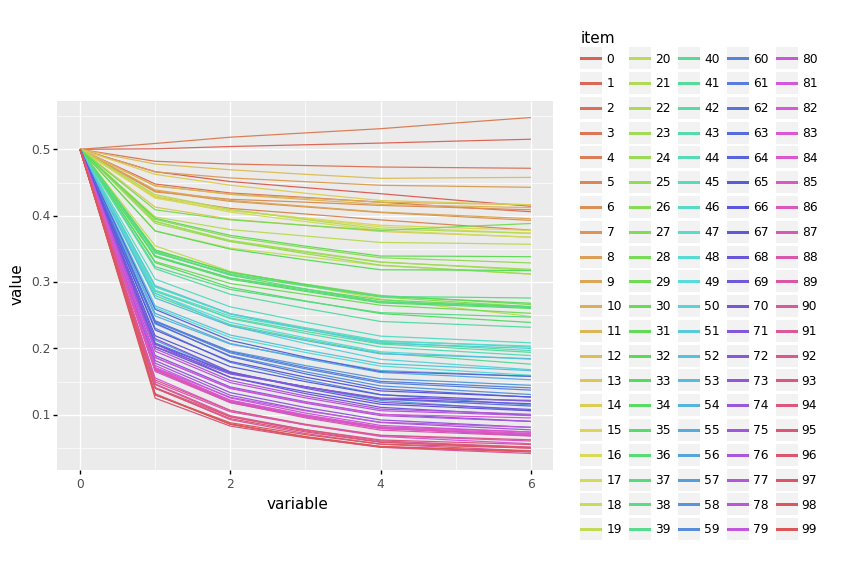

<ggplot: (8791482955466)>

In [11]:
phi_S_pd = pd.DataFrame(phi_S_mat)
phi_S_pd['item'] = np.arange(phi_S_pd.shape[0])
phi_S_pd = pd.melt(phi_S_pd, id_vars=['item'])
phi_S_pd['variable'] = phi_S_pd['variable'].astype(float)
phi_S_pd['item'] = phi_S_pd['item'].astype('category')

(ggplot(phi_S_pd) +
geom_line(aes(x='variable', y='value', color='item'))
)

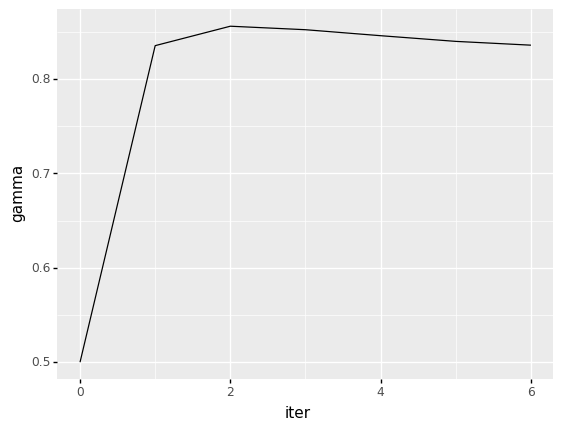

<ggplot: (8791457584252)>

In [12]:
(ggplot(pd.DataFrame(np.hstack((np.arange(gamma_mat.shape[0]).reshape(-1, 1), gamma_mat.reshape(-1 ,1))),
            columns=['iter', 'gamma'])) +
 geom_line(aes(x='iter', y='gamma'))
)



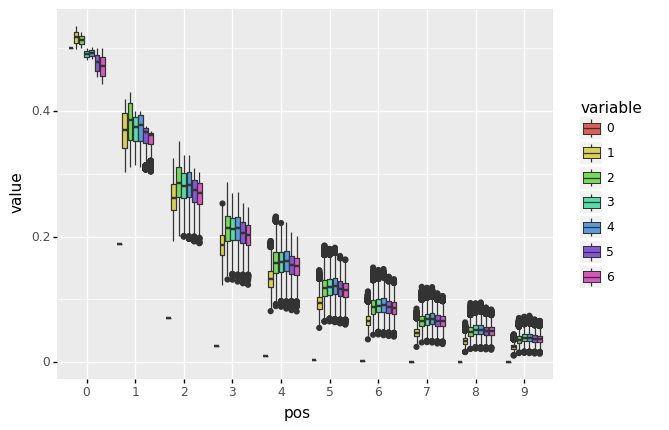

<ggplot: (8791238584613)>

In [13]:
click_probs = [prob.reshape(-1, 1) for prob in res[3]]
click_probs_pd = pd.DataFrame(np.hstack(click_probs))
click_probs_pd['pos'] = np.tile(np.arange(10), int(click_probs_pd.shape[0]/10))
click_probs_pd['pos'] = click_probs_pd['pos'].astype('category')
click_probs_pd

click_probs_pd_flat = pd.melt(click_probs_pd, id_vars=['pos'])
click_probs_pd_flat['variable'] = click_probs_pd_flat['variable'].astype('category')

(ggplot(click_probs_pd_flat) +
 geom_boxplot(aes(x='pos', y='value', fill='variable'))
)



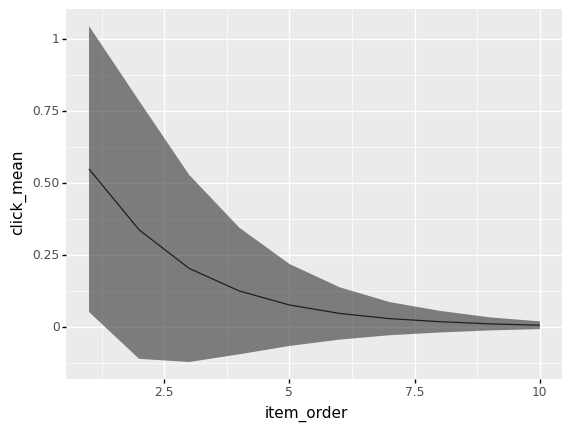

<ggplot: (8792216157657)>

In [14]:
def flatten_index(df):
  df_copy = df.copy()
  df_copy.columns = ['_'.join(col).rstrip('_') for col in df_copy.columns.values]
  return df_copy.reset_index()

real_click = click_data
real_click['item_order'] = real_click['item_order'].astype('int')

res = real_click.groupby(['item_order']).agg({'click': ['mean', 'var']}).pipe(flatten_index)
res
res['upper'] = res['click_mean'] + 2*res['click_var']
res['lower'] = res['click_mean'] - 2*res['click_var']

(ggplot(res)+
 geom_line(aes(x='item_order', y='click_mean')) +
 geom_ribbon(aes(x='item_order', ymin='lower', ymax='upper'), alpha = 0.6)
)

In [ ]:


i = 0
for cp in click_probs:
    pos_entr.append((-real_click_vec * np.log(cp)).reshape(-1, 1))
    neg_entr.append((-(1 - real_click_vec) * np.log(1 - cp)).reshape(-1, 1))

# pos_entr_full = pd.DataFrame(np.hstack((pos_entr)))
# pos_entr_full['pos'] = np.tile(np.arange(10), int(pos_entr_full.shape[0]/10))

# neg_entr_full = pd.DataFrame(np.hstack((pos_entr)))
# neg_entr_full['pos'] = np.tile(np.arange(10), int(pos_entr_full.shape[0]/10))

# pos_entr_pd_plot = pd.melt(pos_entr_full,id_vars=['pos']).groupby(['pos', 'variable']).agg({'value': 'mean'}).\
#     pipe(flatten_index)
# pos_entr_pd_plot = pos_entr_pd_plot.rename(columns={'v_a_l_u_e': 'value'})
# pos_entr_pd_plot['pos'] = pos_entr_pd_plot['pos'].astype('int')
# pos_entr_pd_plot['variable'] = pos_entr_pd_plot['variable'].astype('category')

# pos_entr_pd_plot.pivot(index='pos', columns='variable', values='value')
# #pos_entr_pd_plot.pivot('variable')

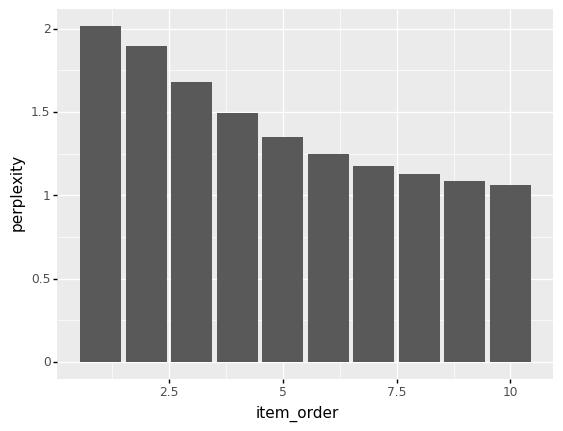

<ggplot: (8791911600628)>

In [49]:
sessions = real_click['session'].max()+1 # as the first index equals 0

perplex_table = (pd.concat((real_click['item_order'], click_probs_pd[6], real_click['click']), axis=1)
                 .rename(columns={6: 'est', 'click': 'real'}))

perplex_table = perplex_table.assign(
    entr = perplex_table['real']*np.log2(perplex_table['est'])+
        (1-perplex_table['real'])*np.log2(1-perplex_table['est']),
    pos_entr = perplex_table['real']*np.log2(perplex_table['est']),
    neg_entr = (1-perplex_table['real'])*np.log2(1-perplex_table['est'])
)
                

perp_dat = (perplex_table
     .groupby('item_order')
     .agg({'entr': 'mean',
           'pos_entr': 'mean',
           'neg_entr': 'mean'})
     .reset_index()
     .assign(perplexity=lambda x: 2**(-x.entr),
            pos_perplexity=lambda x: 2**(-x.pos_entr),
            neg_perplexity=lambda x: 2**(-x.neg_entr))
)

perp_dat.to_csv("./")

(ggplot(perp_dat) +
    geom_bar(aes(x='item_order', y='perplexity'), stat='identity'))

In [50]:
perplex_table

,item_order,est,real,entr,pos_entr,neg_entr
0,1,0.476866,0.0,-0.934748,-0.0,-0.934748
1,2,0.363454,0.0,-0.651664,-0.0,-0.651664
2,3,0.287076,0.0,-0.488180,-0.0,-0.488180
3,4,0.233312,0.0,-0.383289,-0.0,-0.383289
4,5,0.172086,0.0,-0.272447,-0.0,-0.272447
...,...,...,...,...,...,...
250565,6,0.119660,0.0,-0.183868,-0.0,-0.183868
250566,7,0.086853,0.0,-0.131081,-0.0,-0.131081
250567,8,0.063446,0.0,-0.094565,-0.0,-0.094565
250568,9,0.050488,0.0,-0.074742,-0.0,-0.074742
